# Baseline Models

To begin with, we attempted several basic models simply based on our own understanding and reasonable conjectures about the financial market.

The first part is a daily linear regression analysis. It's expected that we will show that blindly modeling daily price movements with a Linear Regression is noisy.

While the second part is a weekly analysis including varieties of random walk. It's mainly due to the fact that the dataset contains a series of weekly data denoting the demand, supply, and other fundamental aspects of crude oil. Thus there is a fairly solid motive for us to assume the **great inertia (or autocorrelation in statistical terms) and time dependency of crude oil price**. In that way, this week's oil price is likely to depend on previous weeks' situations, simulating a random walk.



In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


# Load the dataset
df = pd.read_csv('shortened_oil_data.csv')

# Convert Date column and set as index
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)




# 1. Linear Regression (Baseline ML) 

This model attempts to predict the next day/week's price directly using a weighted sum of all available features (Inventory, Production, RSI, etc.) from the current day/week.

$$\hat{P}_{t+1} = \beta_0 + \beta_1 X_{1,t} + \beta_2 X_{2,t} + \dots + \beta_n X_{n,t} + \epsilon$$

Where:

$\hat{P}_{t+1}$: Predicted Price for next day/week.

$X_{i,t}$: Value of feature $i$ (e.g., Inventory) at current day/week $t$.

$\beta_i$: Learned coefficients.



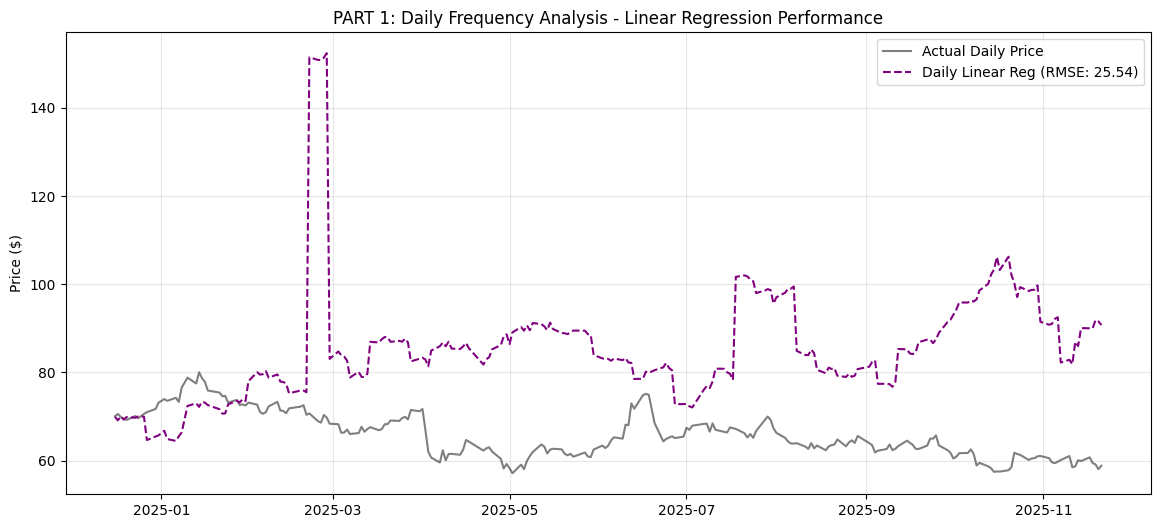


[PART 1 RESULT] Daily Linear Regression RMSE: 25.5381


In [ ]:
df_daily = df.copy()
df_daily['Target_Next_Day'] = df_daily['Crude_Oil'].shift(-1)
df_daily = df_daily.dropna()

d_train_size = int(len(df_daily) * 0.8)
d_train = df_daily.iloc[:d_train_size]
d_test = df_daily.iloc[d_train_size:]

X_d_train = d_train.drop(columns=['Target_Next_Day'])
y_d_train = d_train['Target_Next_Day']
X_d_test = d_test.drop(columns=['Target_Next_Day'])
y_d_test = d_test['Target_Next_Day']

# Standardize because daily features have different scales (Prices vs RSI)
d_scaler = StandardScaler()
X_d_train_s = d_scaler.fit_transform(X_d_train)
X_d_test_s = d_scaler.transform(X_d_test)

lr_daily = LinearRegression()
lr_daily.fit(X_d_train_s, y_d_train)
pred_daily = lr_daily.predict(X_d_test_s)

rmse_daily = np.sqrt(mean_squared_error(y_d_test, pred_daily))

plt.figure(figsize=(14, 6))
plt.plot(y_d_test.index, y_d_test, label='Actual Daily Price', color='black', alpha=0.5)
plt.plot(y_d_test.index, pred_daily, label=f'Daily Linear Reg (RMSE: {rmse_daily:.2f})', color='purple', linestyle='--')
plt.title('PART 1: Daily Frequency Analysis - Linear Regression Performance')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n Daily Linear Regression RMSE: {rmse_daily:.4f}")

We then switch to to Weekly frequency and compare 4 Models (RW vs ML). But before that, we need to pre-process the data. 

In [ ]:
# We want to keep ONLY the Target (Crude_Oil) and Weekly Fundamentals.
# We must remove Daily Market Data (Gold, SP500, DXY, etc.) and Technicals.

# List of specific financial/market columns to drop
market_cols_to_drop = [
    'Brent_Oil', 'USD_CAD', 'DXY', 'Emerging_Mkt', 'Gold', 'Copper', 
    'Heating_Oil', 'Junk_Bond', 'Transportation', 'Natural_Gas', 
    'Oil_Services', 'Gasoline', 'Inflation_Tips', 'Energy_Stocks', 
    'SP500', 'Oil_VIX', 'US10Y', 'Crack_Spread_321', 'Gold_Oil_Ratio', 
    'Copper_Oil_Ratio', 'Transport_Oil_Ratio', 'Service_Oil_Ratio'
]

# Drop specific market columns if they exist
df_filtered = df.drop(columns=[c for c in market_cols_to_drop if c in df.columns])

# Drop Technical Indicators (Columns containing these keywords)
tech_keywords = ['SMA', 'BB_', 'RSI', 'MACD', 'Ret_', 'Vol_', 'ROC_', 'Lag', 'Dist_SMA']
for keyword in tech_keywords:
    df_filtered = df_filtered.loc[:, ~df_filtered.columns.str.contains(keyword)]

print(f"Original Column Count: {df.shape[1]}")
print(f"Filtered Column Count: {df_filtered.shape[1]} (Only Fundamentals + Crude Oil)")

# !!! Resample to Weekly Frequency
# We use 'W-FRI' to end the week on Friday.
# We take the mean to get the average price/value for that week.
weekly_df = df_filtered.resample('W-FRI').mean().dropna(how='all')

# Create the Target: Price of the Next Week
target_col = 'Crude_Oil'
weekly_df['Target_Next_Price'] = weekly_df[target_col].shift(-1)

# Drop the last row since it has no target (NaN)
data = weekly_df.dropna().copy()


train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

print(f"Training Samples: {len(train_data)}, Test Samples: {len(test_data)}")

Original Column Count: 467
Filtered Column Count: 412 (Only Fundamentals + Crude Oil)
Training Samples: 200, Test Samples: 51


Then, the model regarding the linear regression is run as follows:

In [22]:
# Uses all weekly fundamental features to predict absolute price.
# Even without financial data, this may still overfit if N_features is large.

X_cols_raw = [c for c in data.columns if c != 'Target_Next_Price']
X_train_m1 = train_data[X_cols_raw]
y_train_m1 = train_data['Target_Next_Price']
X_test_m1 = test_data[X_cols_raw]
y_test_m1 = test_data['Target_Next_Price']

# Standardize features (Crucial for Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_m1)
X_test_scaled = scaler.transform(X_test_m1)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train_m1)
pred_m1 = lr.predict(X_test_scaled)

# 2. Random Walk (Naive Baseline)

This model assumes the market is efficient and the best predictor for next week's price is simply this week's price.$$\hat{P}_{t+1} = P_t$$

Where:

$P_t$: Actual Price at current week $t$.

In [ ]:
# Logic: Best predictor of tomorrow is today
pred_m2 = test_data[target_col].values


# 3. Smoothed Random Walk (2-Week Average)

This model assumes the current price might contain noise, so it uses the average of the last two weeks as the prediction anchor.$$\hat{P}_{t+1} = \frac{P_t + P_{t-1}}{2}$$

In [ ]:
# Logic: Smooth out noise
rolling_mean = data[target_col].rolling(window=2).mean()
pred_m3 = rolling_mean.iloc[train_size:].values

# Handle edge case: If the first prediction is NaN due to rolling window
if np.isnan(pred_m3[0]):
    pred_m3[0] = pred_m2[0]


# 4.  Supply/Demand Calibrated Random Walk (Augmented)

This model uses the Random Walk as a base ($P_t$) but "calibrates" it by predicting the percentage return ($\hat{r}_{t+1}$) based on changes in supply and demand fundamentals.$$\hat{r}_{t+1} = \alpha + \sum_{i=1}^{k} \lambda_i \Delta F_{i,t}$$

$$\hat{P}_{t+1} = P_t \times (1 + \hat{r}_{t+1})$$

Where:


$\hat{r}_{t+1}$: Predicted return for next week.


$\Delta F_{i,t}$: Percentage change in fundamental factor $i$ (e.g., % change in Inventory).

$\lambda_i$: Coefficients learned via Lasso Regularization (sparse selection).

In [ ]:
# Logic: Predict % Return using fundamental changes, then apply to Current Price.
# Formula: Price_Next = Price_Current * (1 + Predicted_Return)

# Feature Engineering: Convert Levels to % Changes for Stationarity
aug_df = pd.DataFrame()
aug_df['Target_Next_Return'] = data['Target_Next_Price'] / data[target_col] - 1
aug_df['Price_Current'] = data[target_col]

feature_cols = [c for c in data.columns if c not in ['Target_Next_Price']]
for col in feature_cols:
    pct_change = data[col].pct_change().replace([np.inf, -np.inf], np.nan)
    aug_df[f'{col}_PctChange'] = pct_change.fillna(0)

aug_train = aug_df.iloc[:train_size]
aug_test = aug_df.iloc[train_size:]

X_aug_train = aug_train[[c for c in aug_df.columns if '_PctChange' in c]]
y_aug_train = aug_train['Target_Next_Return']
X_aug_test = aug_test[[c for c in aug_df.columns if '_PctChange' in c]]

lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_aug_train, y_aug_train)
pred_return = lasso.predict(X_aug_test)
pred_m4 = aug_test['Price_Current'] * (1 + pred_return)

/var/folders/9y/bjlqdj_x61bd0m36_h3tcy680000gn/T/ipykernel_3039/4094157174.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aug_df[f'{col}_PctChange'] = pct_change.fillna(0)
/var/folders/9y/bjlqdj_x61bd0m36_h3tcy680000gn/T/ipykernel_3039/4094157174.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  aug_df[f'{col}_PctChange'] = pct_change.fillna(0)
/var/folders/9y/bjlqdj_x61bd0m36_h3tcy680000gn/T/ipykernel_3039/4094157174.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

Then, let's see how everything goes:

--------------------------------------------------
Model 1: Weekly Linear Regression RMSE: 34.5867
Model 2: Weekly Random Walk       RMSE: 2.5835
Model 3: Weekly Smoothed RW       RMSE: 2.8053
Model 4: Weekly Calibrated RW     RMSE: 2.5939
--------------------------------------------------


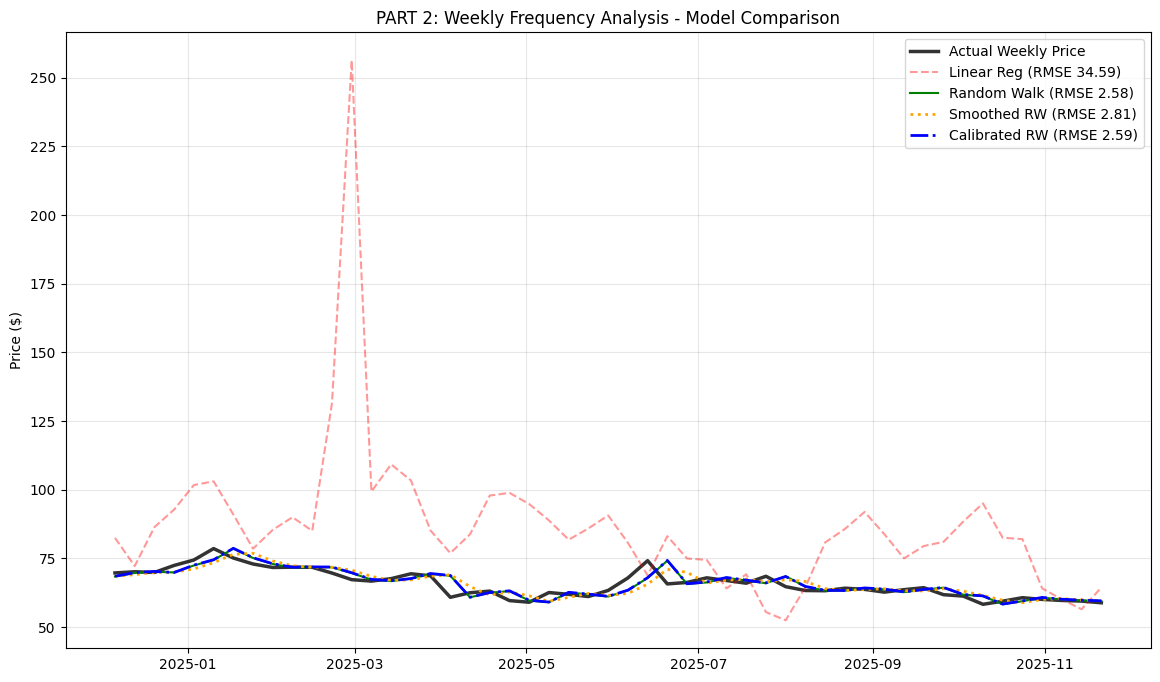


[INSIGHT] Top Fundamentals driving the Calibration (Model 4):
4W_US_Unacc_Crude_PctChange    0.000284
US_Unacc_Crude_PctChange       0.000006
dtype: float64


In [26]:
y_true = test_data['Target_Next_Price']
rmse_m1 = np.sqrt(mean_squared_error(y_true, pred_m1))
rmse_m2 = np.sqrt(mean_squared_error(y_true, pred_m2))
rmse_m3 = np.sqrt(mean_squared_error(y_true, pred_m3))
rmse_m4 = np.sqrt(mean_squared_error(y_true, pred_m4))

print("-" * 50)
print(f"Model 1: Weekly Linear Regression RMSE: {rmse_m1:.4f}")
print(f"Model 2: Weekly Random Walk       RMSE: {rmse_m2:.4f}")
print(f"Model 3: Weekly Smoothed RW       RMSE: {rmse_m3:.4f}")
print(f"Model 4: Weekly Calibrated RW     RMSE: {rmse_m4:.4f}")
print("-" * 50)

# 2.4 Plot Part 2: Weekly Comparison
plt.figure(figsize=(14, 8))
plt.plot(y_true.index, y_true, label='Actual Weekly Price', color='black', linewidth=2.5, alpha=0.8)
plt.plot(y_true.index, pred_m1, label=f'Linear Reg (RMSE {rmse_m1:.2f})', color='red', linestyle='--', alpha=0.4)
plt.plot(y_true.index, pred_m2, label=f'Random Walk (RMSE {rmse_m2:.2f})', color='green', linestyle='-', linewidth=1.5)
plt.plot(y_true.index, pred_m3, label=f'Smoothed RW (RMSE {rmse_m3:.2f})', color='orange', linestyle=':', linewidth=2)
plt.plot(y_true.index, pred_m4, label=f'Calibrated RW (RMSE {rmse_m4:.2f})', color='blue', linestyle='-.', linewidth=2)

plt.title('PART 2: Weekly Frequency Analysis - Model Comparison')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show Lasso Coefficients
coefs = pd.Series(lasso.coef_, index=X_aug_train.columns)
print("\n[INSIGHT] Top Fundamentals driving the Calibration (Model 4):")
print(coefs[coefs != 0].abs().sort_values(ascending=False).head(5))

# Findings based on the primary models

This set of results is classic and carries **profound financial significance**.

### Core Finding: High Market Efficiency (Random Walk is King)
Note that Model 2 (Random Walk) defeated all competitors with an RMSE of 2.5835.

This validates the Efficient Market Hypothesis (EMH) within the weekly crude oil timeframe.

It implies that the current week's price already encapsulates almost all available information.

Trying to beat "simple inertia" using publicly available EIA supply/demand data (which everyone sees) is incredibly difficult. And this suggests that crude oil prices at this frequency are primarily driven by Trend and Momentum, rather than weekly micro-changes in inventory.

### The "Spurious Regression" Trap
Model 1 (Linear Regression) collapsed with a massive RMSE of 34.58.

This is, of course, a textbook level of Overfitting.

When one throw dozens of fundamental indicators (Inventory, Production, etc.) directly into a linear model to predict Absolute Price, the model forces itself to memorize every bit of noise in the training set.


Once applied to the testing set (unseen data), these memorized relationships completely break down.

### Time Value: Recency Bias (Newer is Better)
Model 3 (Smoothed RW) performed significantly worse (RMSE 2.80) than Model 2 (2.58).

Therefore, **smoothing (averaging) actually destroyed value**.

By averaging the last two weeks, one artificially introduced Lag.

In a volatile market like crude oil, "The Latest Information" (Current Price) is far more valuable than "Old Information" (Last Week's Price). While smoothing reduces noise, it also dilutes critical trend signals.

### Model 4's Convergence 
Model 4 (Calibrated RW) produced an RMSE (2.59) almost identical to Model 2 (2.58), differing by only 0.01.

It proves that Lasso worked exactly as intended—it likely compressed the coefficients of the vast majority of your fundamental features to zero.


The tiny 0.01 difference suggests that Lasso might have kept one or two very weak features that turned out to be noise in the test set, slightly dragging down performance.